In [1]:
# Add the parent directory of the current working directory to the Python path at runtime. 
# In order to import modules from the src directory.
import os
import sys 
import openai
from dotenv import load_dotenv, find_dotenv

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)

load_dotenv(find_dotenv())
openai.api_key = os.environ["OPENAI_API_KEY"]

BASEPATH = os.environ["BASEPATH"]

In [2]:
import tomllib
import pandas as pd
import seaborn as sns
import igraph as ig

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec


from src.utils.plotting import convert_size

sns.set_context("paper")

In [3]:
def parse_directories():
    """
    Parse the directories from the configuration file.
    Returns:
    - directories: dict
    """
    with open('../config/directories.toml', 'rb') as f:
        configurations = tomllib.load(f)

    return configurations

In [10]:
directories = parse_directories()
csv_path = os.path.join(BASEPATH, directories['internal']['intermediate']['csv'],'Psychology')
article_file = os.path.join(csv_path, "articles_merged_cleaned_filtered_clustered.csv")
cluster_file = os.path.join(csv_path, "clusters_defined_distinguished_trends_assessed_density.csv")

article_df = pd.read_csv(article_file)
cluster_df = pd.read_csv(cluster_file)

graph_path = os.path.join(BASEPATH, directories['internal']['intermediate']['graphs'])
graph_file = os.path.join(graph_path, "citation_density.graphml")

figure_path = os.path.join(BASEPATH, directories['internal']['manuscript']['figures'], 'Figure_02')
os.makedirs(figure_path, exist_ok=True)

table_path = os.path.join(BASEPATH, directories['internal']['manuscript']['tables'])
os.makedirs(table_path, exist_ok=True)

In [11]:
# Save a reduced version of the cluster dataframe to a table
keep_columns = ['Cluster ID', 'Size', 'Title', 'Description', 'Keywords']
reduced_cluster_df = cluster_df.loc[:, keep_columns].copy()

# Rename the Size column to Number of Articles
reduced_cluster_df.rename(columns={'Size': 'Number of Articles'}, inplace=True)
reduced_cluster_df.to_excel(os.path.join(table_path, 'supplementary_table_01.xlsx'), index=False)

In [12]:
# Load the citation graph (it provides the weights of the edges for the citation graph)
density_graph = ig.load(graph_file)

# Create a directed graph
citation_graph = ig.Graph(directed=True)

# Add unique vertices (nodes)
cluster_ids = cluster_df["Cluster ID"].astype(str).unique()
citation_graph.add_vertices(cluster_ids)

# Assign labels to nodes
citation_graph.vs["label"] = cluster_ids

# Extract edges efficiently using zip()
edges = set()  # Use a set to prevent duplicate edges

for source, target in zip(cluster_df["Most Citing Cluster"], cluster_df["Cluster ID"]):
    if pd.notna(source):  # Ensure source is not NaN
        edges.add((str(source), str(target)))

for source, target in zip(cluster_df["Cluster ID"], cluster_df["Most Cited Cluster"]):
    if pd.notna(target):  # Ensure target is not NaN
        edges.add((str(source), str(target)))

# Add edges to the graph
citation_graph.add_edges(list(edges))

# Remove duplicate edges (igraph automatically prevents exact duplicates, but simplifying ensures clean structure)
citation_graph.simplify()

# Assign weights to the edges
for edge in citation_graph.es:
    source = edge.source
    target = edge.target
    edge["weight"] = density_graph[source, target]

# Print summary
print(citation_graph.summary())


IGRAPH DNW- 110 198 -- 
+ attr: label (v), name (v), weight (e)


### Figure 2 Panels

In [13]:
# Define the panel size (width, height) in centimeters
figure_size = [89, 89]

# Convert the panel size to inches
figure_size_inch = convert_size(*figure_size)

# Define the color palette
colors = ['#785ef0', '#fe6100']

# Define hue order
hue_order = ['Review', 'Research']

# Define the font sizes
fontsize_text = 6
fontsize_ticks = 5

# Define step size for x-axis 
num_clusters = cluster_df["Cluster ID"].nunique()
step = 10  # Ensure at least step=1

# Define dpi (for the graph)
dpi = 300


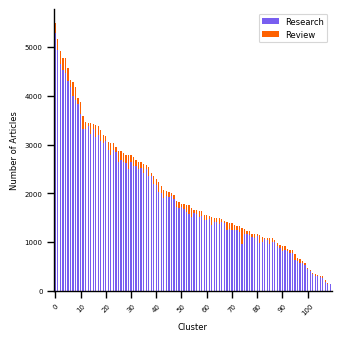

In [14]:
# panel A Bar graph of the number of review and research articles per cluster (stacked)

# Group the articles by cluster and type
grouped = article_df.groupby(["Cluster ID", "Type"]).size().reset_index(name="count")

# Pivot the table
pivot = grouped.pivot(index="Cluster ID", columns="Type", values="count").fillna(0)

# Plot the bar graph
plt.figure(figsize=figure_size_inch)
pivot.plot(kind="bar", stacked=True, color=colors, ax=plt.gca())
sns.despine()
plt.xlabel("Cluster", fontsize=fontsize_text)
plt.ylabel("Number of Articles", fontsize=fontsize_text)
# ensure ticks and labels are visible by reducing the number of ticks
plt.xticks(range(0, num_clusters, step), fontsize=fontsize_ticks, rotation=45)
plt.yticks(fontsize=fontsize_ticks)
plt.legend(title=None, fontsize=fontsize_text, title_fontsize=fontsize_text)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, "panel_a.svg"), format="svg")
plt.show()



/tmp/ipykernel_30551/3792958668.py:62: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  plt.savefig(os.path.join(figure_path, 'panel_b.svg'), format='svg', bbox_inches='tight')
/home/mario/miniconda3/envs/trends_env/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


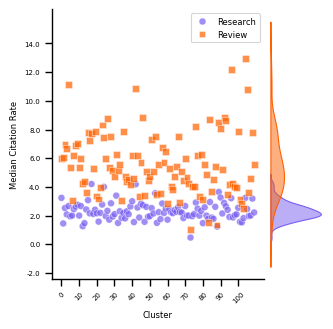

In [15]:
# Panel B Combined scatter and density plot of median citation rates per cluster separated by article type
medians = article_df.groupby(["Cluster ID", "Type"])["Citation Rate"].median().unstack()

# Create a GridSpec layout with main plot and marginal density plot
fig = plt.figure(figsize=figure_size_inch, constrained_layout=True)
gs = GridSpec(1, 2, width_ratios=[4, 1], wspace=0.05)  # Adjust width ratios as needed

# Main plot (Scatter plot)
ax_main = fig.add_subplot(gs[0, 0])

# Plot the scatter plot
sns.scatterplot(
    data=medians,
    palette=colors,
    s=25,  
    markers=['o', 's'],  # Different markers for each type
    alpha=0.7,
    ax=ax_main
)

# Customize the main plot
sns.despine(ax=ax_main)
ax_main.set_xlabel('Cluster', fontsize=fontsize_text)
ax_main.set_ylabel('Median Citation Rate', fontsize=fontsize_text)

# Adjust x-ticks to reduce clutter

ax_main.set_xticks(range(0, num_clusters, step))
ax_main.set_xticklabels(range(0, num_clusters, step), fontsize=fontsize_ticks, rotation=45)

# Adjust y-ticks
ax_main.set_yticks(ax_main.get_yticks())
ax_main.set_yticklabels([f"{tick:.1f}" for tick in ax_main.get_yticks()], fontsize=fontsize_ticks)

# Handle legend
handles, labels = ax_main.get_legend_handles_labels()
# Remove duplicate labels if necessary
unique_labels = dict(zip(labels, handles))
ax_main.legend(unique_labels.values(), unique_labels.keys(), title=None, fontsize=fontsize_text)

# Marginal plot (Density plot)
ax_marginal = fig.add_subplot(gs[0, 1], sharey=ax_main)

# Plot density plots for each article type
for i, type_name in enumerate(medians.columns):
    sns.kdeplot(
        y=medians[type_name].dropna(),
        ax=ax_marginal,
        color=colors[i],
        fill=True,      # Replaces shade=True
        alpha=0.5
    )

# Customize the marginal plot - remove all axes and labels
sns.despine(ax=ax_marginal, left=True, bottom=True, right=True, top=True)
ax_marginal.set_xlabel('', fontsize=fontsize_text)
ax_marginal.set_ylabel('')  # No label for y-axis
ax_marginal.tick_params(axis='x', which='both', bottom=False, labelbottom=False)  # Hide x-axis ticks
ax_marginal.tick_params(axis='y', which='both', left=False, labelleft=False)  # Hide y-axis ticks

# Save the combined plot
plt.savefig(os.path.join(figure_path, 'panel_b.svg'), format='svg', bbox_inches='tight')

# Display the plot
plt.show()


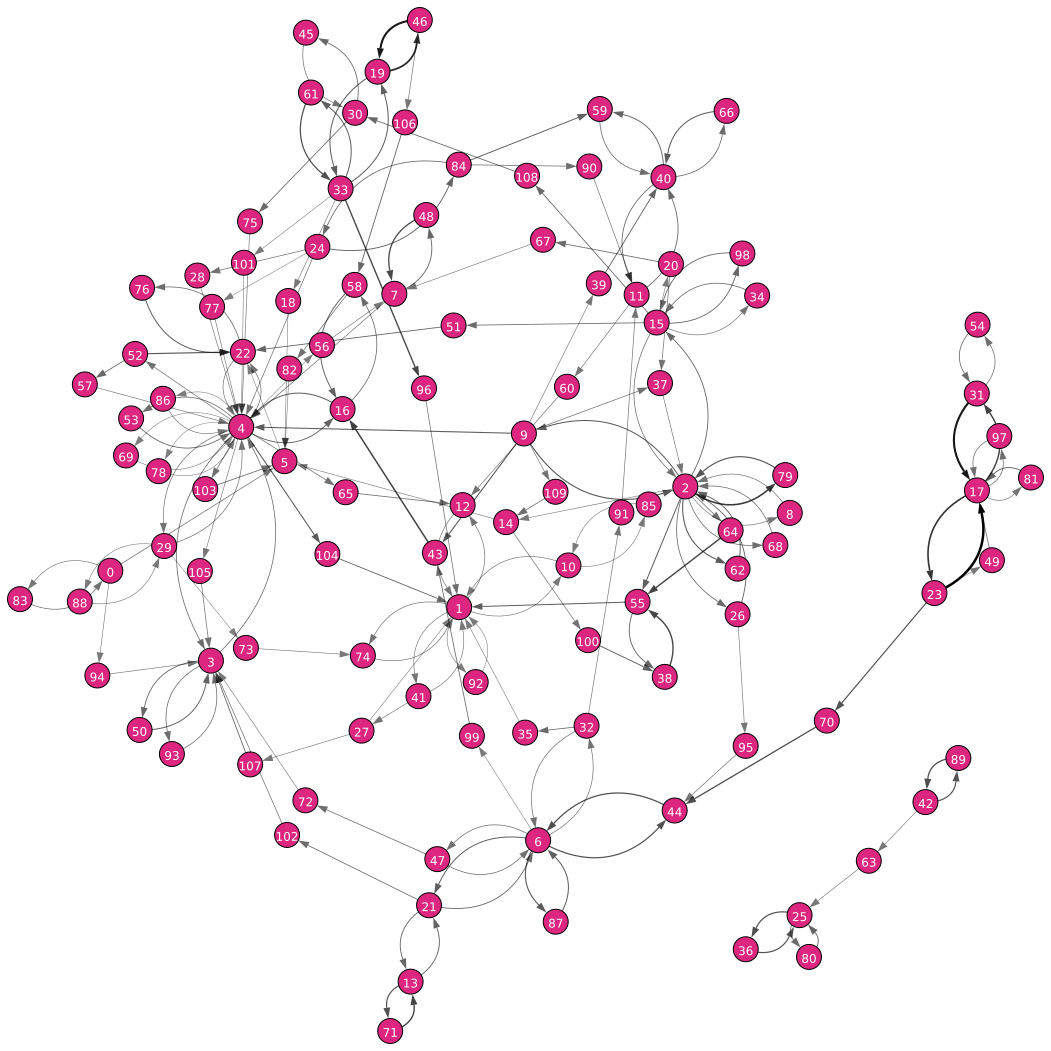

In [16]:
# Panel C Citation graph of neuroscience clusters

fig_size_px = int(figure_size_inch[0] * dpi)

# Define layout
citation_layout = citation_graph.layout_auto()

# Set node size dynamically based on the number of clusters
node_size = max(25, min(40, 400 // len(citation_graph.vs)))  # Keeps nodes readable

# Estimate a font size that fits inside the node
label_font_size = int(node_size * 0.5)  # Adjust based on node size

# Calculate edge widths and color based on edge weights
edge_weights = citation_graph.es["weight"]
max_weight = max(edge_weights)
min_weight = min(edge_weights)
normed_weights = [(weight - min_weight) / (max_weight - min_weight) for weight in edge_weights]
edge_widths = [0.5 + 2 * weight for weight in normed_weights]
edge_colors = [f"rgba(0, 0, 0, {0.5+weight*0.5})" for weight in normed_weights]

# Define plot settings
visual_style = {
    "layout": citation_layout,
    "vertex_label": citation_graph.vs["label"],  
    "vertex_color": "#dc267f",
    "vertex_size": node_size, 
    "vertex_label_size": label_font_size, 
    "vertex_label_dist": 0,  
    "vertex_label_color": "white", 
    "edge_width": edge_widths,  
    "edge_color": edge_colors,  
    "edge_arrow_size": 0.75, 
    "bbox": (fig_size_px, fig_size_px), 
    "margin": 20,  
}

# Save the graph as an SVG file
output_path = os.path.join(figure_path, "panel_c.svg")
ig.plot(citation_graph, output_path, **visual_style)

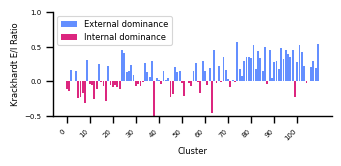

In [17]:
# Panel D Bar graph of Krackhardt E/I ratio for references (Reference Krackhardt column) per cluster

positive_krackhardt = cluster_df["Reference Krackhardt"] > 0
negative_krackhardt = cluster_df["Reference Krackhardt"] < 0

# Plot the Krackhardt E/I ratio for references
plt.figure(figsize=convert_size(89,44.5))

# Plot a bar graph for positive Krackhardt E/I ratios

plt.bar(
    cluster_df[positive_krackhardt].index,
    cluster_df[positive_krackhardt]["Reference Krackhardt"],
    color='#648fff',
    label='External dominance',
)

# Plot a bar graph for negative Krackhardt E/I ratios
plt.bar(
    cluster_df[negative_krackhardt].index,
    cluster_df[negative_krackhardt]["Reference Krackhardt"],
    color='#dc267f',
    label='Internal dominance',
)

sns.despine()
plt.xlabel("Cluster", fontsize=fontsize_text)
plt.ylabel("Krackhardt E/I Ratio", fontsize=fontsize_text)
plt.ylim(-0.5, 1)
plt.xticks(range(0, num_clusters, step), fontsize=fontsize_ticks, rotation=45, ha='right')
plt.yticks(fontsize=fontsize_ticks)
plt.legend(title=None, fontsize=fontsize_text)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, "panel_d.svg"), format="svg")
plt.show()


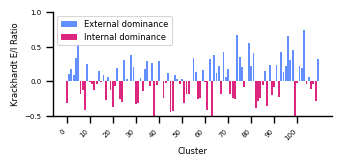

In [18]:
# Panel E Bar graph of Krackhardt E/I ratio for citations (Citation Krackhardt column) per cluster

positive_krackhardt = cluster_df["Citation Krackhardt"] > 0
negative_krackhardt = cluster_df["Citation Krackhardt"] < 0

# Plot the Krackhardt E/I ratio for citations
plt.figure(figsize=convert_size(89,44.5))

# Plot a bar graph for positive Krackhardt E/I ratios
plt.bar(
    cluster_df[positive_krackhardt].index,
    cluster_df[positive_krackhardt]["Citation Krackhardt"],
    color='#648fff',
    label='External dominance',
)

# Plot a bar graph for negative Krackhardt E/I ratios
plt.bar(
    cluster_df[negative_krackhardt].index,
    cluster_df[negative_krackhardt]["Citation Krackhardt"],
    color='#dc267f',
    label='Internal dominance',
)

sns.despine()
plt.xlabel("Cluster", fontsize=fontsize_text)
plt.ylabel("Krackhardt E/I Ratio", fontsize=fontsize_text)
plt.ylim(-0.5, 1)
plt.xticks(range(0, num_clusters, step), fontsize=fontsize_ticks, rotation=45, ha='right')
plt.yticks(fontsize=fontsize_ticks)
plt.legend(title=None, fontsize=fontsize_text)
plt.tight_layout()
plt.savefig(os.path.join(figure_path, "panel_e.svg"), format="svg")
plt.show()

### Supplementary

In [19]:
table_path = os.path.join(BASEPATH, directories['internal']['manuscript']['tables'])
os.makedirs(table_path, exist_ok=True)

In [20]:
graph_metric_df = cluster_df[["Cluster ID", "Reference Krackhardt", "Citation Krackhardt"]].copy()

# Add in-degree and out-degree to the DataFrame (taking weighted edges into account)
graph_metric_df.loc[:, "Citations (in-degree)"] = citation_graph.strength(mode="IN", weights="weight")
graph_metric_df.loc[:, "References (out-degree)"] = citation_graph.strength(mode="OUT", weights="weight")

# Add betweenness centrality to the DataFrame (taking weighted edges into account)
graph_metric_df.loc[:, "Betweenness Centrality"] = citation_graph.betweenness(weights="weight")

# Add PageRank to the DataFrame
graph_metric_df.loc[:, "PageRank"] = citation_graph.pagerank(weights="weight")

# Save the DataFrame as supplementary table 2
graph_metric_df.to_csv(os.path.join(table_path, "supplementary_table_02.csv"), index=False)
graph_metric_df.to_excel(os.path.join(table_path, "supplementary_table_02.xlsx"), index=False)